# Restaurant Sales Forecast

## Outlines:
- [1. Introduction](#1) <br>
- [2. Problem Statement](#2) <br>
- [3. Data Exploration](#3) <br>
    * [3.1. Missing data Analysis](#31) <br>
    * [3.2. Data Validation](#32) <br>
        + [3.2.1. Is special occasion?](#321) <br>
    * [3.3. Restaurant level analysis](#33) <br>
- [4. Prepare Data(Data Munging)](#4) <br>
    * [4.1 Feature Extraction](#41) <br>
    * [4.2 Data Exploration with newly extracted feature](#42) <br>
- [5. Modelling and Evaluation](#5) <br>
    * [5.1 Univariate Forecasting](#51) <br>
        + [5.1.1 ARIMA](#511) <br>
        + [5.1.2 SARIMA](#512) <br>
    * [5.2 Multivariate Forecasting](#52) <br>
        + [5.2.1 ARIMAX](#521) <br>
        + [5.2.2 SARIMAX](#522) <br>
    * [5.3 Problem Statement 2: What happens when we end Pot Pie category?](#53) <br>
- [6. Prediction for July month (for holdout set) for Problem 1 and 2](#6) <br>
- [7. Future Scope](#7) <br>


<a id='1'></a>

# 1. Introduction
KFC (short for Kentucky Fried Chicken) is an American fast food restaurant chain specializes in fried chicken.A common problem at KFC is to predict expected sales based on previous customer purchasing behavior.We are having data from November 2019 through June 2020 for several different KFC restaurants. 
The fields are: 
- restaurant_id: ID of a specific restaurant 
- customer_id: ID of a specific customer 
- transaction_id: ID of a specific transaction (aka 1 transaction == 1 order) 
- busy_dt: date of the transaction 
- category: type of product sold 
- combo_qty: amount of product sold in the transaction 
- combo_amount: sales amount for the products sold in the transaction.

<a id='2'></a>
# 2. Problem Statement 
In this notebook we will focus only on <b>restaurant level</b> sales analysis and forecast. 

## Problem 1:
    Prediction of total sales in July for all restaurants
    
## Problem 2:
    Prediction of total sales in July for all restaurants when we eliminate Pot Pie Category.
    

In [1]:
# import libraries
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from statsmodels.tsa.seasonal import seasonal_decompose
from sklearn.metrics import mean_absolute_error
import datetime as dt
# import warnings filter
from warnings import simplefilter
# ignore all future warnings
simplefilter(action='ignore', category=FutureWarning)
%matplotlib inline

<a id='3'></a>
# 3. Data Exploration

In [2]:
# Load Data
data = pd.read_csv('2020_problem_set_data.csv')
data.shape

(251659, 7)

<a id='31'></a>
## 3.1 Missing Data Analysis:

In [3]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 251659 entries, 0 to 251658
Data columns (total 7 columns):
 #   Column          Non-Null Count   Dtype  
---  ------          --------------   -----  
 0   restaurant_id   251659 non-null  int64  
 1   customer_id     251659 non-null  int64  
 2   transaction_id  251659 non-null  int64  
 3   busy_dt         251659 non-null  object 
 4   category        251659 non-null  object 
 5   combo_qty       251659 non-null  int64  
 6   combo_amount    251659 non-null  float64
dtypes: float64(1), int64(4), object(2)
memory usage: 13.4+ MB


<b>There is no missing data.</b>

<a id='32'></a>
## 3.2 Data Validation:

In this section, we are validating the data and will simply remove invalid entry if any.

In [4]:
# Appropriate type conversion for columns
to_cat = ['restaurant_id','customer_id','transaction_id']
data[to_cat] = data[to_cat].astype('category')
data['busy_dt'] = pd.to_datetime(data['busy_dt'])

# Sort by date is important step of time series
data.sort_values(['restaurant_id','busy_dt'], inplace=True)
data.describe(include='all')

,restaurant_id,customer_id,transaction_id,busy_dt,category,combo_qty,combo_amount
count,251659.0,251659.0,251659.0,251659,251659,251659.000000,251659.000000
unique,5.0,86161.0,146576.0,241,6,NaN,NaN
top,0.0,68523.0,69798.0,2020-03-01 00:00:00,Low End COB,NaN,NaN
freq,70925.0,329.0,16.0,2158,102464,NaN,NaN
first,NaN,NaN,NaN,2019-11-01 00:00:00,NaN,NaN,NaN
last,NaN,NaN,NaN,2020-06-30 00:00:00,NaN,NaN,NaN
mean,NaN,NaN,NaN,NaN,NaN,1.135421,8.792780
std,NaN,NaN,NaN,NaN,NaN,0.621663,8.852234
min,NaN,NaN,NaN,NaN,NaN,1.000000,0.300000
25%,NaN,NaN,NaN,NaN,NaN,1.000000,4.790000


<b>Data Summary:</b>
- Total unique restaurants - 5
- Total unique customers - 86161
- Total major categories - 6
- Total days - 241

We found unusual values for 'combo_qty' and 'combo_amount' columns. Also it's bit surprising to see 16 transaction entries for transaction_id '69798'. We will analyse it further.

<a id='321'></a>
### 3.2.1 Is special occasion?
Unsual 'combo_qty' possible to happen if particular customer offering party for any special reson like birthday, marriage, other personal reasons like corporate promotion, special achievement. Assume threshold 15 for 'combo_qty'. If 'combo_qty> 15 then it is special occasion.

In [5]:
# Analysing special occasion
print('Possible special occasions:', data[data['combo_qty']>15].shape[0])

Possible special occasions: 48


In [6]:
# Analysing unusual transaction
data[data['transaction_id'] == 69798]

,restaurant_id,customer_id,transaction_id,busy_dt,category,combo_qty,combo_amount
29371,1,25883,69798,2020-03-02,Low End COB,1,5.00
40793,1,25883,69798,2020-03-02,Low End COB,1,5.00
57923,1,25883,69798,2020-03-02,Low End COB,1,1.50
57925,1,25883,69798,2020-03-02,Low End COB,2,3.00
72799,1,25883,69798,2020-03-02,Low End COB,2,3.00
72800,1,25883,69798,2020-03-02,Low End COB,1,1.50
82546,1,25883,69798,2020-03-02,High End COB,1,4.79
95389,1,25883,69798,2020-03-02,High End COB,1,4.79
108989,1,25883,69798,2020-03-02,Bowls/Salads,2,10.00
125114,1,25883,69798,2020-03-02,Bowls/Salads,2,10.00


Also this transaction is indication of special personal occasion. Now everything else is good to go.

<a id='33'></a>
## 3.3 Restaurant Level Analysis:
Our first goal in problem statement 1 is to foracast the sales at restaurant level on daily basis. Therefore, restaurant level analysis is important in this context. We will be extracting different attributes from the given data. and try to analyse there correlation with daily total sale.

In [7]:
# Daily number of customer at each restaurant
no_of_cust = data.groupby(['restaurant_id','busy_dt'])['customer_id'].nunique()

# Daily number of transaction at each restaurant
no_of_trans = data.groupby(['restaurant_id','busy_dt'])['transaction_id'].nunique()

# Daily total sales at restaurant
total_sale = data.groupby(['restaurant_id','busy_dt'])['combo_amount'].sum()

# Restaurant level dataframe
rest_df = pd.concat([no_of_cust,no_of_trans,total_sale],axis=1)

rest_df.rename(columns = {'customer_id':'no_of_cust', 'transaction_id':'no_of_trans', 'combo_amount':'total_sale'},inplace = True)
rest_df.reset_index(inplace=True)

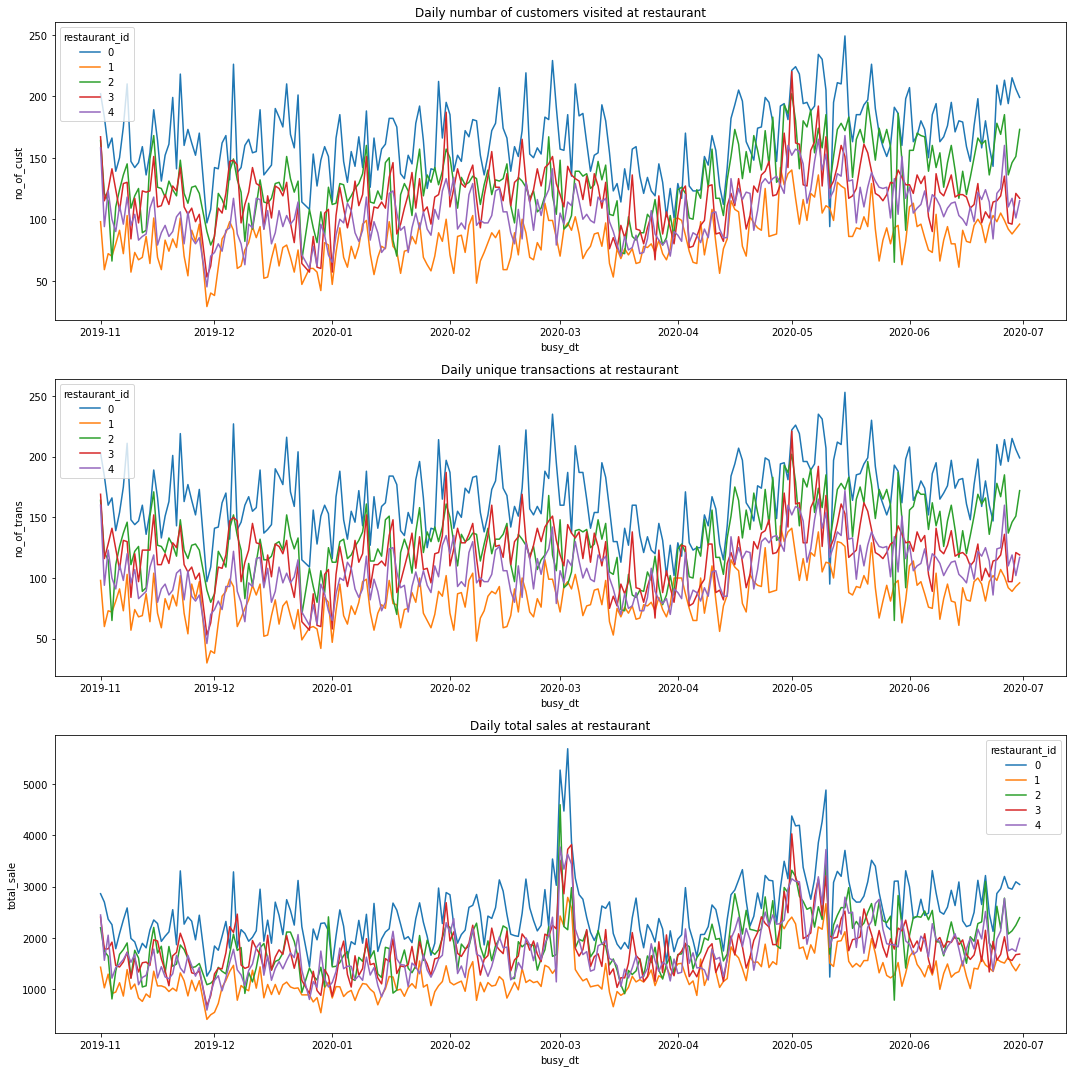

In [8]:
# Restaurant level visualization for each attributes

fig,(ax1,ax2,ax3) = plt.subplots(3,1,figsize=(15,15))
sns.lineplot(data=rest_df,x='busy_dt',y='no_of_cust', hue='restaurant_id', ax= ax1)
ax1.title.set_text('Daily numbar of customers visited at restaurant')
sns.lineplot(data=rest_df,x='busy_dt',y='no_of_trans', hue='restaurant_id', ax= ax2)
ax2.title.set_text('Daily unique transactions at restaurant')
sns.lineplot(data=rest_df,x='busy_dt',y='total_sale', hue='restaurant_id', ax= ax3)
ax3.title.set_text('Daily total sales at restaurant')
plt.tight_layout()

Restaurant(id=0) seems to be popular restaurant because number of daily customers visited is higher most of the time compared to other restaurants. As well as revenue generated by this restaurant is highest among all restaurants in the dataset(Refer total_sale plot). 
KFC made large sales during the start of March 2020 and in the May 2020.

As well as, all restaurant shows somewhat increase in daily total sale over the time. For this we would try to visualize weekly,monthly average sale plot. In the following plot, we can clearly see the monthly increasing trend of sale.

Text(0.5, 1.0, 'Restaurant 4 time series plot')

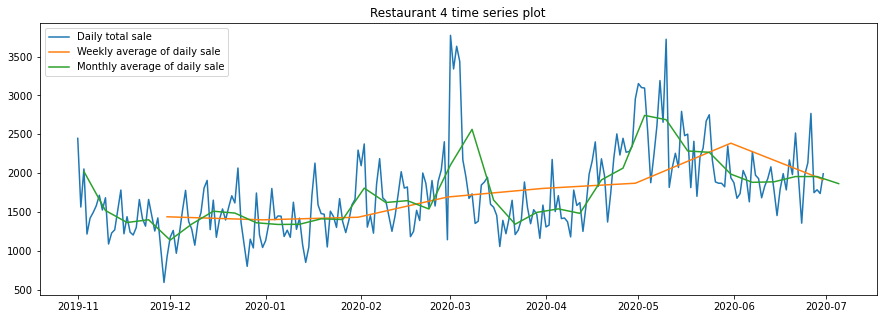

In [9]:
# Analyse monthly and weekly trend for sales

rest4_ts = rest_df[rest_df['restaurant_id']==4][['busy_dt','total_sale']].set_index('busy_dt')
rest4_ts.sort_index(inplace=True)
plt.figure(figsize=(15,5))
plt.plot(rest4_ts, label = 'Daily total sale')
plt.plot(rest4_ts.resample('M').mean(), label = 'Weekly average of daily sale')
plt.plot(rest4_ts.resample('W').mean(), label = 'Monthly average of daily sale')
plt.legend(loc='upper left')
plt.title('Restaurant 4 time series plot')

In [10]:
# Daily number of each category sold at restaurant
cat_qty = data.groupby(['restaurant_id','busy_dt','category'])['combo_qty'].sum()


In [11]:
# Daily number of each category sold at restaurant
cat_qty = data.groupby(['restaurant_id','busy_dt','category'])['combo_qty'].sum()


# Daily amount generated for each category for each restaurant
cat_amt = data.groupby(['restaurant_id','busy_dt','category'])['combo_amount'].sum()

rest_cat_df = pd.concat([cat_qty,cat_amt],axis = 1)
rest_cat_df.reset_index(inplace=True)
rest_cat_df.rename(columns ={'combo_qty':'cat_qty', 'combo_amount':'cat_amt'}, inplace=True)

In [12]:
def category_plots(df,res_id):
    df = df[df['restaurant_id']==res_id].copy()
    fig,(ax1,ax2) = plt.subplots(2,1,figsize=(15,10))
    sns.lineplot(data=df,x='busy_dt',y='cat_qty', hue='category', ax= ax1)
    ax1.title.set_text('Daily quantity sold for each category at restaurant '+str(res_id))
    sns.lineplot(data=df,x='busy_dt',y='cat_amt', hue='category', ax= ax2)
    ax2.title.set_text('Daily amount generated by each category at restaurant '+str(res_id))

We focus on analysing Restaurant 4. 

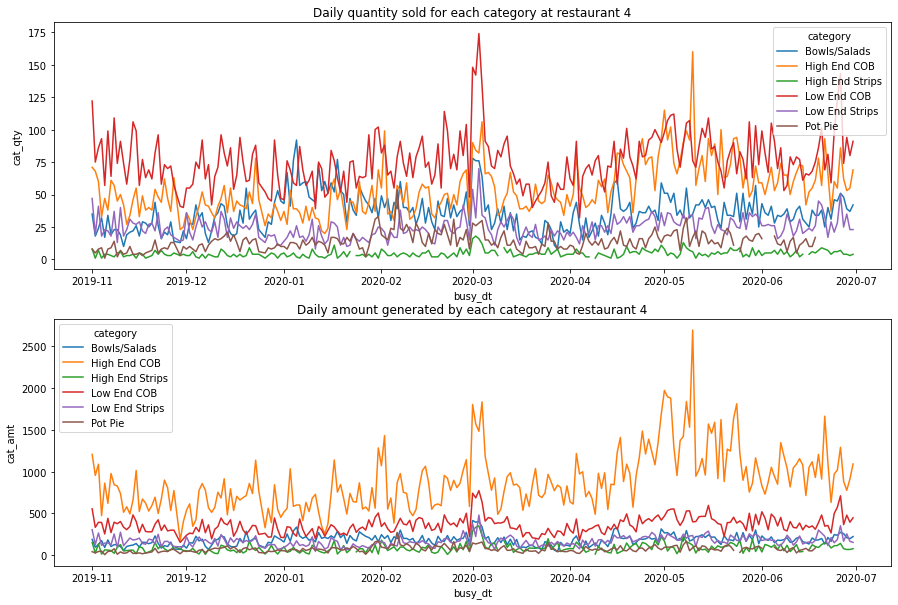

In [13]:
category_plots(rest_cat_df,4)

'Low end cob' is highly sold category. But revenue generated by 'High end cob' is higher than any other categories. 'Pot Pie' seems to be on lowest end for revenue generation. It's sell ended on  couple of weeks before June end(for restaurant 0).(refer line plot for pot pie in following graph)

In above plot, we can see sudden increase in quantity of bowls/salads category for Jan 2020. Our guess, there could some new dishes might have added under this category. But sale plot doesn't show significant increase. Therefore our second guess could be special offer(i.e. discount) might had been running for almost whole month for this category.

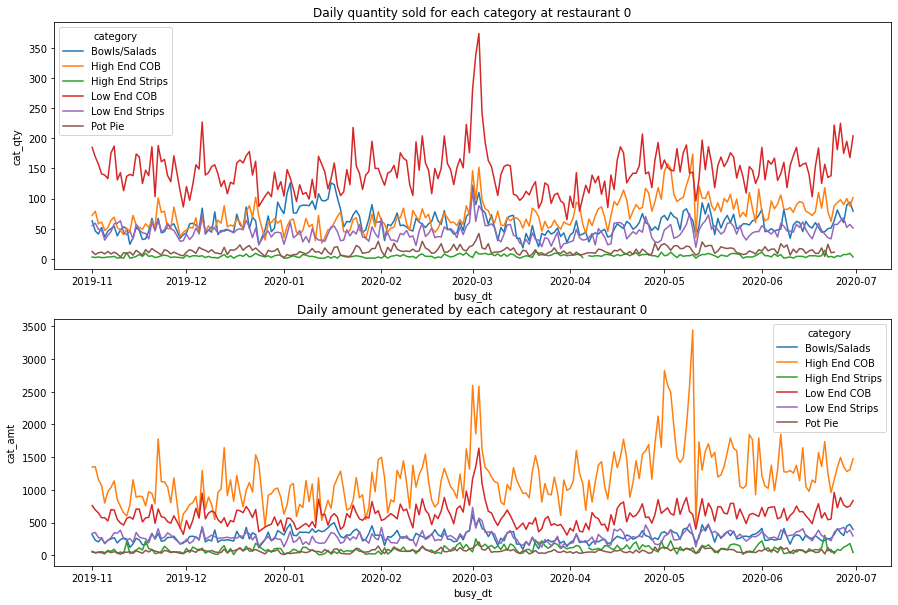

In [14]:
# sample plot for other restaurant say restaurant 0
category_plots(rest_cat_df,0)

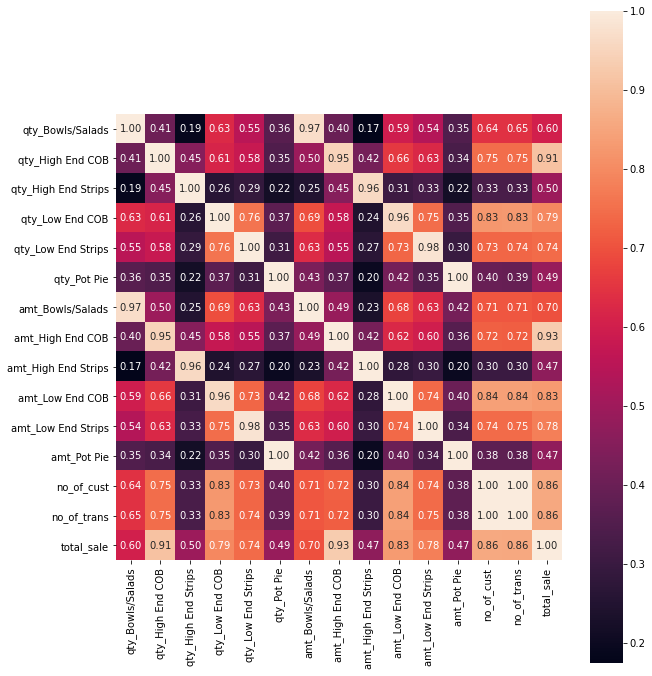

In [15]:
# Finding out correlation of features with total_sale

cq = cat_qty.unstack().add_prefix('qty_').reset_index(drop=True)
cm = cat_amt.unstack().add_prefix('amt_').reset_index(drop = True)
overall_df = pd.concat([cq,cm,rest_df], axis=1).set_index(['restaurant_id','busy_dt'])
plt.figure(figsize=(10,12))
sns.heatmap(overall_df.corr(), annot=True, fmt='.2f', square=True)

All features have positive correlation with total sale. Among those qty_pot_pie and amt_pot_pie has lowest correlation with total sale. This is the indication that 'Pot Pie' category has less contribution towards daily sale.

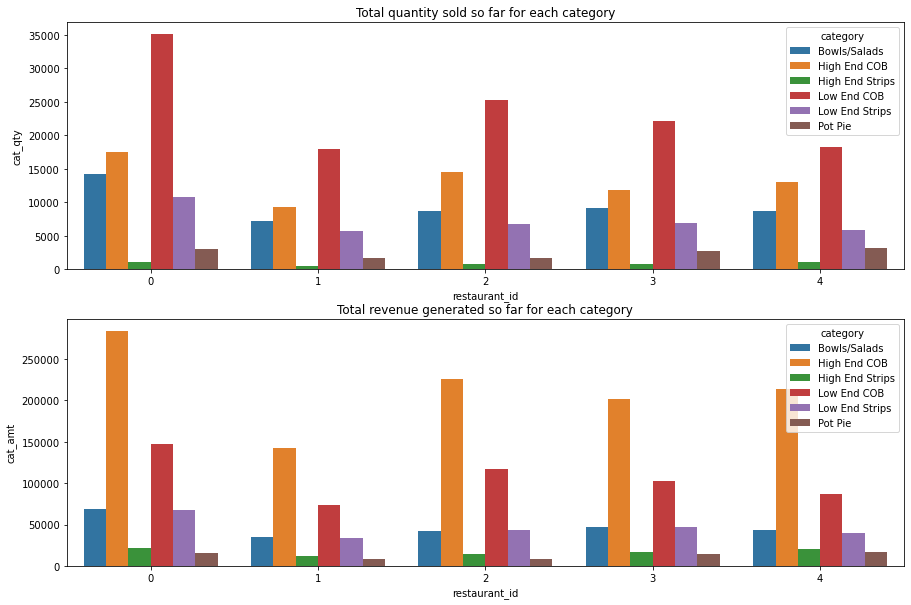

In [16]:
# Total qty sold for each category and total revenue generated for each category

fig,(ax1,ax2) = plt.subplots(2,1,figsize=(15,10) )
tot_df = rest_cat_df.groupby(['restaurant_id','category'])['cat_qty','cat_amt'].sum().reset_index().copy()
sns.barplot(data = tot_df, x='restaurant_id',hue='category',y='cat_qty', ax=ax1 )
ax1.title.set_text('Total quantity sold so far for each category')
sns.barplot(data = tot_df, x='restaurant_id',hue='category',y='cat_amt', ax=ax2 )
ax2.title.set_text('Total revenue generated so far for each category')

Above graph is self explanotory to tell us about sale and popular category. Revenue generated by 'Pot Pie' is lowest as compared to other categories at all restaurants.Therefore, KFC might have decided to eliminte this category for future.( Refer to second problem statement)

In [17]:
# Counting days for which this category was absent 
cat_df = pd.pivot_table(index = ['restaurant_id','busy_dt'], columns='category', values = 'cat_amt', data=rest_cat_df)
cat_df.isnull().sum()

category
Bowls/Salads         1
High End COB         0
High End Strips     70
Low End COB          0
Low End Strips       1
Pot Pie            114
dtype: int64

In [18]:
cat_df.reset_index(inplace=True)

We found many missing instances of Pot Pie. It means Pot pie was not available for those particular days. It is only possible if it is ran out or restaurant removed that category from their menu. It gives us some clue about extracting feature that would be useful for our model.

All above features are extracted for the sake of understanding the data. But these features are not useful for modelling in current case. As they would not available upfront while forecasting for future instances.

<a id='4'></a>
## 4. Prepare Data (Data Munging):

On next step, we are planning to develop time series model. In that case, time related features would really made impact on forecasting. Therefore, in this section we will extract some time related features.

<a id='41'></a>

### 4.1 Feature extraction:
For time related feature etraction we will use 'busy_dt' a datetime column in our dataset. As well as, based on previous analysis, we will extract some features to provide useful information about avilability of category.

In [19]:
def create_features(df,cat_df=None,ishist=False):
    """
    Extract useful features from available data
    
    inputs:
    df = row dataframe
    cat_df = category data frame
    ishist = is this historical data
    
    output:
    return dataframe with additinal new features
    
    """
    dff = df.copy()
    dff['month'] = dff['busy_dt'].dt.month
    dff['weekday'] =dff['busy_dt'].dt.dayofweek
    dff['quarter'] = dff['busy_dt'].dt.quarter
    
    # Weekend Assumption Friday, Saturday, Sunday
    dff['IsWeekend'] = dff['weekday']>3 
    dff['IsWeekend'] = dff['IsWeekend'].astype(int)
    
    if ishist == True:
        # Availability of less popular item at restaurant
        dff['PotPieAv'] = cat_df['Pot Pie'].notnull()
        dff['PotPieAv'] = dff['PotPieAv'].astype(int)
        
    return dff

# Dropping 'no_of_trans' and 'no_of_cust' though it is available in historical data. 
# It is not possible to know upfront for future instances.
rest_df = create_features(rest_df,cat_df, ishist=True)
rest_df.drop(['no_of_trans','no_of_cust'],axis=1, inplace =True)

In [20]:
rest_df.head()

,restaurant_id,busy_dt,total_sale,month,weekday,quarter,IsWeekend,PotPieAv
0,0,2019-11-01,2861.11,11,4,4,1,1
1,0,2019-11-02,2697.43,11,5,4,1,1
2,0,2019-11-03,2366.10,11,6,4,1,1
3,0,2019-11-04,2257.70,11,0,4,0,1
4,0,2019-11-05,1789.32,11,1,4,0,1


<a id='42'></a>
### 4.2 Data Exploration with newly extracted features

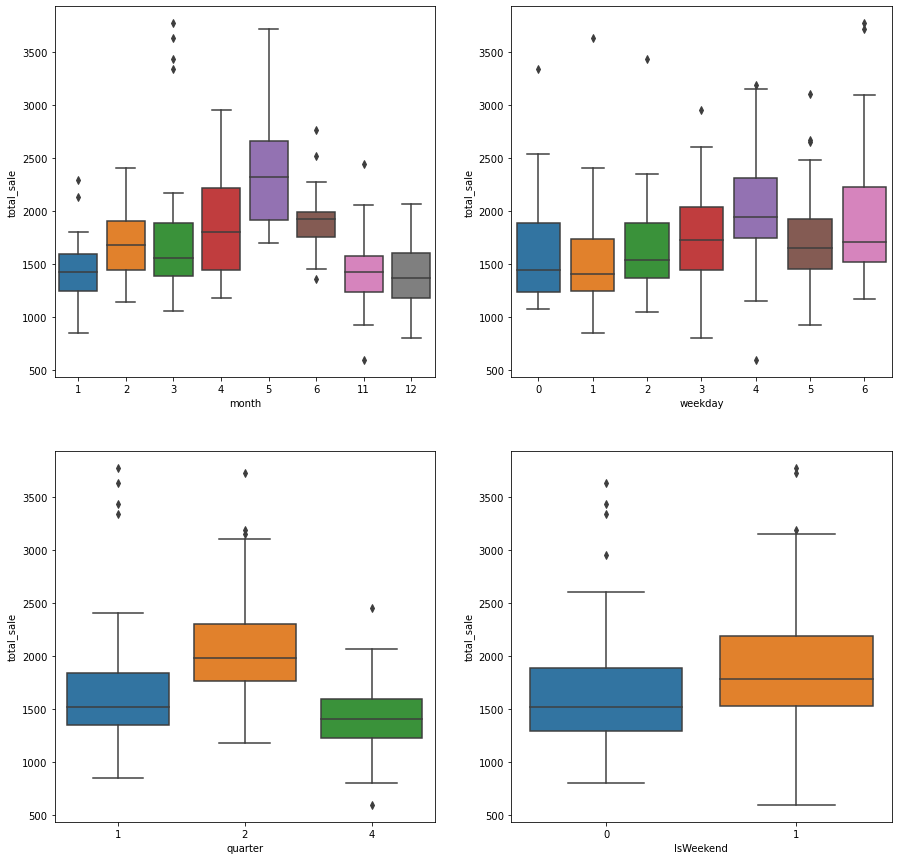

In [21]:
# Analysis with newly extracted feature for restaurant 4

rest4_df = rest_df[rest_df['restaurant_id'] == 4]

fig, ((ax1, ax2),(ax3,ax4)) = plt.subplots(2,2, figsize=(15,15))
sns.boxplot(data = rest4_df, x='month',y='total_sale', ax=ax1)
sns.boxplot(data = rest4_df, x='weekday',y='total_sale', ax=ax2)
sns.boxplot(data = rest4_df, x='quarter',y='total_sale', ax=ax3)
sns.boxplot(data = rest4_df, x='IsWeekend',y='total_sale', ax=ax4)

We have included Friday in weekend because weekly plot shows high median sale on Friday.(Refer weekday plot) Our guess,it is possible that from Friday evening people want to relax and looking for some outing at restaurant. Outliers could be indicator of occasional event.

<b> Final Data:</b>
* Features - 'restaurant_id','busydt', 'month', 'weekday','quarter','IsWeekend', 'PotPieAv'
* Target - total_sale

<a id='5'></a>
## 5. Modelling and Evaluation:
We are planning to use time series models to forecast our daily total sale for each restaurant. In this section, we will be only focusing on restaurant 4. and experimenting with following types of models.
1. Univariate Forecasting (ARMA/ARIMA/SARIMA)
2. Multivariate Forecasting (ARMAX/ARIMAX/SARIMAX)

<a id='51'></a>
### 5.1 Univariate Forecasting:
Time series should be stationary in order to apply most time series models. If it isn't we should stationarize it by applying some transformation or differencing.


### Model Selection:

Models have parameter
- ARMA (AR term(p), MA term(q))
- ARIMA (AR term(p), MA term(q), Integrated term(d))
- SARIMA-Seasonal ARIMA ( AR term(p), MA term(q),Integrated term(d), sesonal order((sp,sd,sq,s))


#### Stationarity Check
We apply Augmented Dickey-Fuller(adfuller) test to check for stationarity.

Adfuller Hypothesis testing for time series:
- Null Hypothesis(H0): It is non-stationary
- Alternate Hypothesis(H1): It is staionary

If the p-value of ‘Test Statistic’ is less than the ‘Critical Value’ then time series is stationary. We assume this critical value 0.01.

In [22]:
from statsmodels.tsa.stattools import adfuller

def adfuller_test(sales, reg='nc'):
    """ Adaptive Dickey fuller Testing for time series
    
    inputs-
    
    sale - input time series
    n - 
    
    """
    
    result=adfuller(sales, regression=reg) 
    labels = ['ADF Test Statistic','p-value']
    for value,label in zip(result,labels):
        print(label+' : '+str(value))
        if label == 'p-value':
            if value >0.01:
                print('Time Series is not stationary')
            else:
                print('Time series is stationary')

# Stationarity Check for Restaurant 4
print('Stationarity test restaurant 4 Total sale')
adfuller_test(rest4_df['total_sale'],reg='ct')

Stationarity test restaurant 4 Total sale
ADF Test Statistic : -3.5784511487404616
p-value : 0.03171603928907982
Time Series is not stationary


In [23]:
# Time series is not stationary. Let's apply first order differencing and check stationarity
adfuller_test(rest4_df['total_sale'].diff().dropna(), reg='c')

ADF Test Statistic : -10.368788823450334
p-value : 2.2929077214121492e-18
Time series is stationary


When Original-data is not stationary and Diff-data is stationary,the time series is called unit root process.
For unit root process, We use ARIMA or SARIMA model. In above case we need to set d=1.

####  Tuning AR term and MA term:
<b>AR </b> terms can be indentified by PACF plot.  PACF is a partial auto-correlation function. It finds correlation of the residuals (which remains after removing the effects which are already explained by the earlier lag(s)) with the next lag value. we would expect the plot to show a strong relationship to the lag and a trailing off of correlation from the lag onwards.

The ACF tells how many <b>MA</b> terms are required to remove any autocorrelation in the stationarized series. We would expect the ACF for the MA(k) process to show a strong correlation with recent values up to the lag of k, then a sharp decline to low or no correlation.

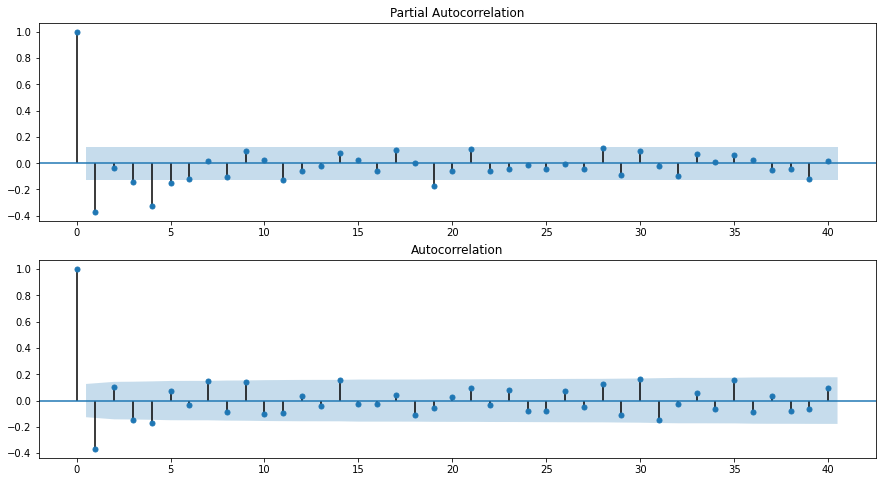

In [24]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima_model import ARIMA

def acf_pacf_plot(series):
    fig,(ax1,ax2) = plt.subplots(2,1,figsize=(15,8))
    plot_pacf(series,lags = 40,ax=ax1)
    plot_acf(series,lags = 40, ax=ax2)
    plt.show()
    
acf_pacf_plot(rest4_df['total_sale'].diff().dropna())
    

we will be fixing p=1 and q=1 based on above plot.
We are able to see some sort of cyclic pattern but not sure. We may need to investigate further if is there any cylic pattern exist.

<a id='511'></a>
### 5.1.1 ARIMA:

First, we would build the ARIMA and analyze the result. Following is the dataset split for modelling and testing/validation
- Train Set: 1 November 2019 to 31 May 2020 (First 211 data points)
- Test Set: 1 June 2020 to 30 June 2020 (Remaining 30 points)

In [25]:
def build_arima(ds,p,d,q,sec):
    """
    Build ARIMA on given time series and plot forecast against actual data.
    
    input:
    ds - time series
    p,d,q - model parameters
    
    output:
    Actual test time series
    Forecasted time series
    Model residual
    """
    
    
    # Train data- time series till 'sec' and Test data time series 'sec' onward
    train = ds[:sec].copy()
    test = ds[sec:].copy()
    
    
    # Fitting ARIMA model on train test
    model = ARIMA(train, order=(p,d,q))
    model_fit = model.fit(disp=0)
    print(model_fit.summary())
    
    
    # Forecasting for next month
    fc, se, conf = model_fit.forecast(30, alpha=0.05)
    
    # Forecast, lower bound and upper bound
    fc = pd.Series(fc, index=test.index)
    lower_bound = pd.Series(conf[:, 0], index=test.index)
    upper_bound = pd.Series(conf[:, 1], index=test.index)
    
    # Plot Actual and forecast along with lower and upperbound
    plt.figure(figsize=(15,5), dpi=100)
    plt.plot(train, label='training')
    plt.plot(test, label='actual')
    plt.plot(fc, label='forecast')
    plt.fill_between(lower_bound.index, lower_bound, upper_bound, 
                 color='k', alpha=.10)
    plt.title('Forecast vs Actuals')
    plt.legend(loc='upper left', fontsize=8)
    plt.show()
    
    
    return test.values, fc.tail(30).values, model_fit.resid
    

In [26]:
# Build ARIMA with on sales time series of restaurant 4
ts = rest4_df[['busy_dt','total_sale']].set_index('busy_dt')
ts.index = pd.DatetimeIndex(ts.index, freq='infer')

C:\Users\Lajar\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:218: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
C:\Users\Lajar\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:218: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


                             ARIMA Model Results                              
Dep. Variable:           D.total_sale   No. Observations:                  210
Model:                 ARIMA(1, 1, 1)   Log Likelihood               -1553.691
Method:                       css-mle   S.D. of innovations            394.629
Date:                Thu, 19 Nov 2020   AIC                           3115.383
Time:                        15:16:19   BIC                           3128.771
Sample:                             1   HQIC                          3120.795
                                                                              
                         coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------
const                  1.9238      6.492      0.296      0.767     -10.800      14.648
ar.L1.D.total_sale     0.3928      0.102      3.860      0.000       0.193       0.592
ma.L1.D.total_sale  

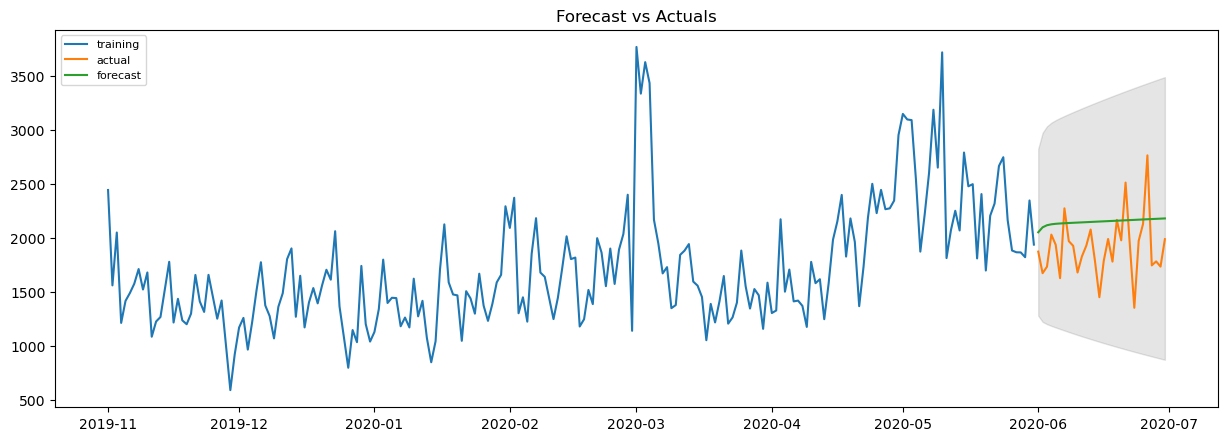

In [27]:
test, forecast, resid  = build_arima(ts,p=1,d=1,q=1,sec=211)

Model forecast seems high frequently and not shows any fluctuation.

#### Error Evaluation: 
we will analyze RMSE, MAPE and accuracy metrics to evaluate performance of any model over test set. 

Error evaluation on test set:
RMSE:360.5286
MAPE:0.1741
Accuracy:0.8259


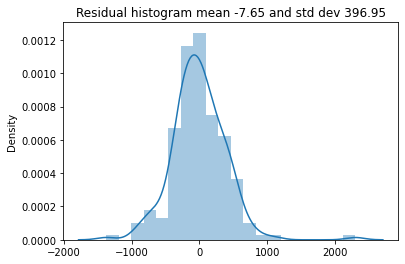

In [28]:
from sklearn.metrics import mean_squared_error

def error_evaluation(forecast,actual, resid):
    """
    Evaluate model forecast against actual
    
    input:
    forecast - Forecasted time series
    actual - Actual time series
    resid - Model Residue
    
    output:
    Evaluation summary and residual plot
    """
    
    rmse = np.sqrt(mean_squared_error(forecast,actual))
    mape = np.mean(abs(forecast - actual)/actual)
    acc = 1-mape
    sns.distplot(resid.values, bins=20, kde=True)
    plt.title('Residual histogram mean {:.2f} and std dev {:.2f}'.format(resid.mean(),resid.std()))
    
    print('RMSE:{:.4f}\nMAPE:{:.4f}\nAccuracy:{:.4f}'.format(rmse,mape,acc))
                   
    
print('Error evaluation on test set:')
error_evaluation(forecast,test, resid)


<a id='512'></a>
### 5.1.2 SARIMA:

ARIMA does not support seasonality. From our previous analysis we have observed there could be seasonality in the time series. With available data, we can only infer about if there is weekly or monthly seasonality. Let's perform seasonal decompose using moving average with freq = 7(for weekly) and freq=30(for monthly)

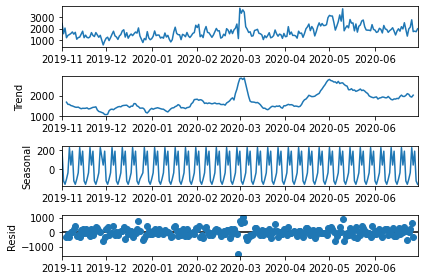

In [29]:
from statsmodels.tsa.seasonal import seasonal_decompose

# Seasonal decompose to analyaze for weekly cycle
resultw = seasonal_decompose(ts, model='additive',freq=7)
resultw.plot()
plt.show()

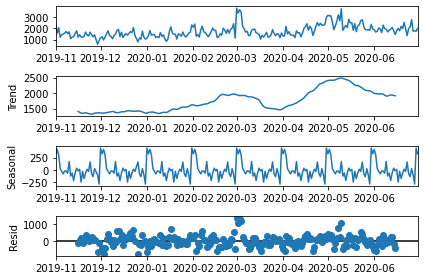

In [30]:
# Seasonal decompose to analyze for monthly cycle
resultm = seasonal_decompose(ts, model='additive',freq=30)
resultm.plot()
plt.show()

From above plot, Weekly cycles are more clearer than monthly one. 

Let's build SARIMA with seasonal order(1,0,1,7)
- sp = s
- sd = 0 (because sd + d should be <=2) so fixed it to 0
- sq = q
- s = 7 based on above analysis

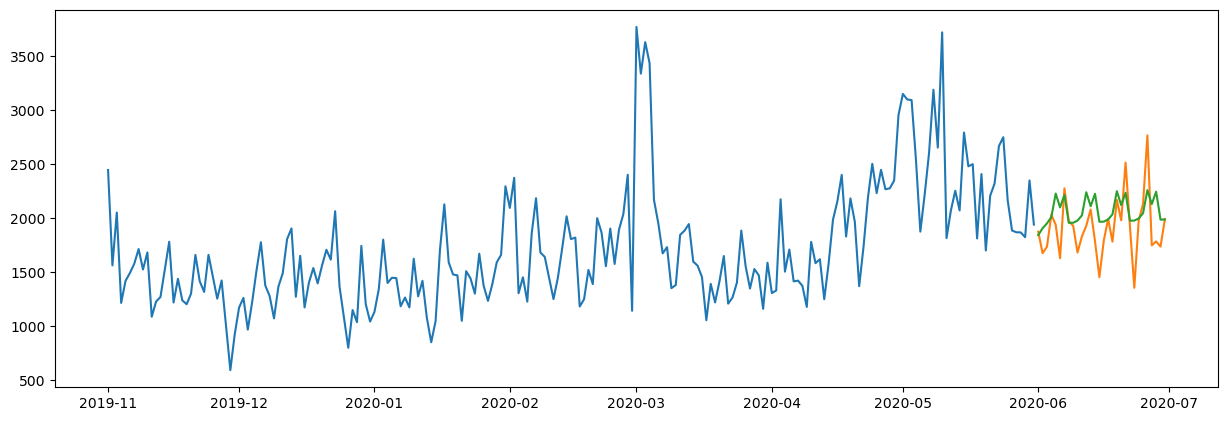

In [31]:
import warnings
warnings.filterwarnings("ignore")

import statsmodels.api as sm
def build_sarima(se,p,d,q,sp,sd,sq,s,sec):
    """ Build SARIMA and evaluate
    
    input:
    se - time series to model
    p,d,q - Model parameter
    sp,sd,sq,s - Seasonal order
    sec - section point for time series
    
    output:
    actual , forecasted time series  and residue
    """
    
    # Build train and test
    train = se[:sec].copy()
    test = se[sec:].copy()
    
    # Fit SARIMA
    mod = sm.tsa.statespace.SARIMAX(train['total_sale'],order=(p,d,q),seasonal_order=(sp,sd,sq,s))
    fit_mod = mod.fit()
    f = fit_mod.predict(start=211,end=240,dynamic=True)
    
    # Plot Forecast
    plt.figure(figsize=(15,5), dpi=100)
    plt.plot(train['busy_dt'],train['total_sale'], label='training')
    plt.plot(test['busy_dt'], test['total_sale'],label='actual')
    plt.plot(test['busy_dt'],f, label='forecast')
    
    return test['total_sale'], f, fit_mod.resid
    
    

t = rest4_df[['busy_dt','total_sale']].copy()
tes, fore, res = build_sarima(t,1,1,1,1,0,1,7,211)


RMSE:281.1204
MAPE:0.1215
Accuracy:0.8785


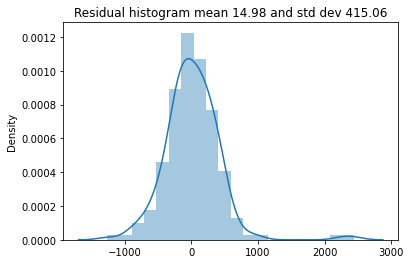

In [32]:
# error analysis
error_evaluation(fore.values,tes.values,res)

auto_arima() uses a stepwise approach to search multiple combinations of p,d,q parameters and chooses the best model that has the least AIC.

<a id='52'></a>
### 5.2 Multivariate Forecasting:

We will add exogenous variable this time to build ARIMA and SARIMA. 

Input Data:
- Exogenous variable - 'month', 'weekday','quarter','IsWeekend', 'PotPieAv'
- Indogenous variable - 'total_sale'

<b>Important Note: We wanted to have one hot encoding for feature but due to some technical glitch we are sticking to the label encoding</b>

In [33]:
def build_arimax(sale,p,d,q,sp,sd,sq,s,sec,exogen):
    """
    Build ARIMAX/SARIMAX and plot forecast against actual. 
    
    input:
    sale - time series to model
    p,d,q,sp,sd,sq,s - model parameter
    sec - section point for time series
    exogen - exogenous variables
    
    output:
    actual, forecasted time series and model residuals
    
    Note: (sp,sd,sq,s)=(0,0,0,0) will lead to ARIMAX or else it is SARIMAX
    
    """
    
    # Train data whole time series except last month and Test data last month
    xtrain = exogen[:sec].copy()
    xtest = exogen[sec:].copy()
    ytrain = sale[:sec].copy()
    ytest = sale[sec:].copy()
    
    # Fitting ARIMAX/SARIMAX model on train test. 
    model = sm.tsa.statespace.SARIMAX(ytrain,order=(p,d,q),seasonal_order=(sp,sd,sq,s),exog = xtrain,
                                enforce_stationarity=False, enforce_invertibility=False)
    model_fit = model.fit(disp=0)
    print(model_fit.summary())
    
    # Forecast and plot 
    f = model_fit.predict(start=211,end=240,dynamic=True, exog=xtest)
    
    plt.figure(figsize=(15,5), dpi=100)
    plt.plot(ytrain, label='training')
    plt.plot(ytest,label='actual')
    plt.plot(ytest.index,f, label='forecast')
    
    return ytest, f, model_fit.resid

<a id='521'></a>
### 5.2.1 ARIMAX 

To use function 'build_arimax' as ARIMAX keep (sp,sd,sq,s) = (0,0,0,0)

                               SARIMAX Results                                
Dep. Variable:             total_sale   No. Observations:                  211
Model:               SARIMAX(1, 1, 1)   Log Likelihood               -1521.822
Date:                Thu, 19 Nov 2020   AIC                           3059.645
Time:                        15:16:22   BIC                           3086.345
Sample:                             0   HQIC                          3070.441
                                - 211                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
month        310.2917     79.086      3.923      0.000     155.285     465.298
weekday       18.5461     20.636      0.899      0.369     -21.900      58.993
quarter    -1111.1327    212.203     -5.236      0.0

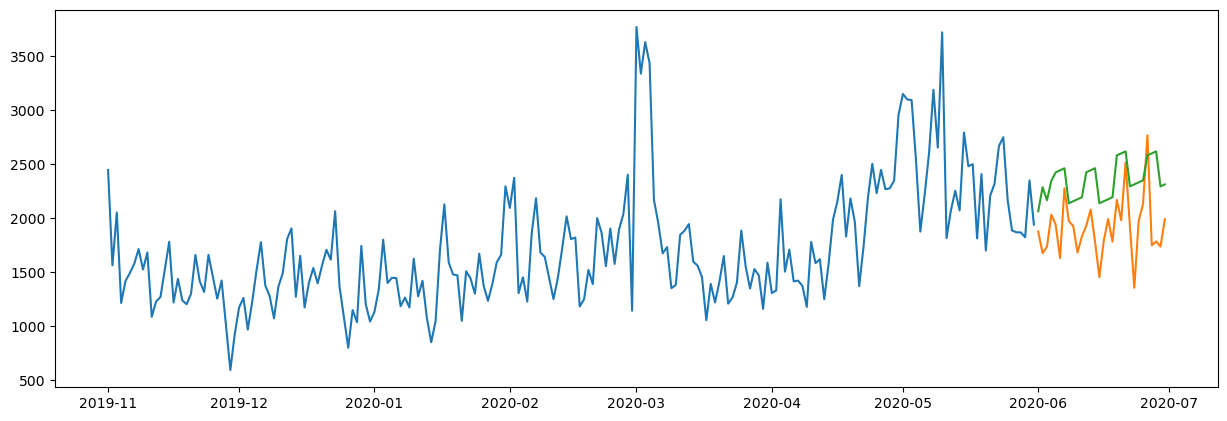

In [34]:
# Build ARIMAX for Restaurant 4 sales data
rest4_df = rest_df[rest_df['restaurant_id']==4].set_index('busy_dt')
rest4_df.index = pd.DatetimeIndex(rest4_df.index, freq='infer')
cols = rest4_df.columns.drop(['total_sale', 'restaurant_id'])
tes,fore,res = build_arimax(rest4_df['total_sale'],1,1,1,0,0,0,0,211,rest4_df[cols])

RMSE:496.5652
MAPE:0.2479
Accuracy:0.7521


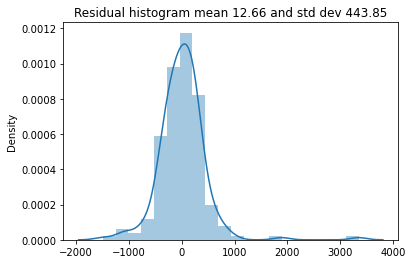

In [35]:
# ARIMAX performance evaluation
error_evaluation(fore.values,tes.values,res)

<a id='522'></a>
### 5.2.2 SARIMAX:
We will add seasonal order (1,0,1,7) in this case same as in SARIMA in previous subsection

                                     SARIMAX Results                                     
Dep. Variable:                        total_sale   No. Observations:                  211
Model:             SARIMAX(1, 1, 1)x(1, 0, 1, 7)   Log Likelihood               -1472.763
Date:                           Thu, 19 Nov 2020   AIC                           2965.526
Time:                                   15:16:23   BIC                           2998.559
Sample:                                        0   HQIC                          2978.892
                                           - 211                                         
Covariance Type:                             opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
month        308.7028     81.476      3.789      0.000     149.013     468.393
weekday       14.9861     23.238      0.645

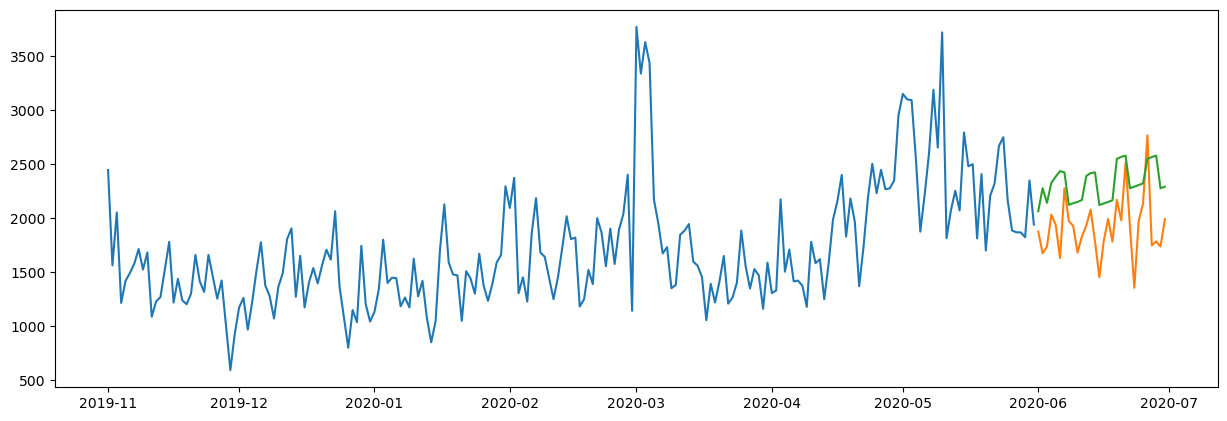

In [36]:
# Build SARIMAX on restaurant 4 sales data
tes,fore,res = build_arimax(rest4_df['total_sale'],1,1,1,1,0,1,7,211,rest4_df[cols])

RMSE:475.1386
MAPE:0.2356
Accuracy:0.7644


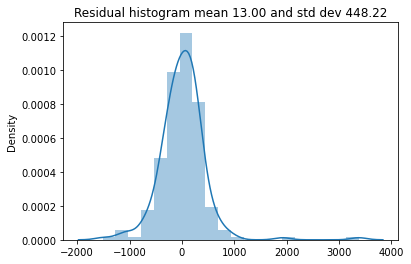

In [37]:
# SARIMAX performance evaluation
error_evaluation(fore.values,tes.values,res)

 ####  Performance Summary :
|Models/Metric|ARIMA | SARIMA | ARIMAX | SARIMAX|
|---|---|---|---|---|
|RMSE|360.52|281.12|496.56|475.13
|MAPE|0.174|0.122|0.247|0.235
|Accuracy|0.83|0.89|0.75|0.76

Based on error evaluation SARIMAX would be a good choice in Multivariate models.In Univariate forecasting, SARIMA is the best as well as it is best among all presented models too. Therefore, we will use SARIMA for first problem statement.

For second problem statement univariate forecasting do not offer a flexibilty to alter features according to our requirement.But in case of multivariate forecasting we can have that flexibility. We will do some experimentation with Multivariate forecasting to observe the effect of PotPie availability on daily total sale. If it does'nt have significant effect, we will go with SARIMA as our final model or else SARIMAX is our final model for second problem statement.

<a id='53'></a>
## 5.3 Problem Statement 2 - What happens if we end Pot Pie?

Until now we were using data till end of May for training and forecasting sale for June comparing it with actual sale.Let's analyze the Pot Pie availability in June

In [38]:
rest4_df[rest4_df['PotPieAv']==0]

,restaurant_id,total_sale,month,weekday,quarter,IsWeekend,PotPieAv
busy_dt,,,,,,,
2020-05-24,4,2750.81,5,6,2,1,0
2020-06-02,4,1675.91,6,1,2,0,0
2020-06-04,4,2033.38,6,3,2,0,0
2020-06-19,4,2169.84,6,4,2,1,0
2020-06-20,4,1980.63,6,5,2,1,0
2020-06-21,4,2515.82,6,6,2,1,0
2020-06-22,4,1923.72,6,0,2,0,0
2020-06-23,4,1355.33,6,1,2,0,0
2020-06-24,4,1975.69,6,2,2,0,0


There are around 14 days the Pot Pie was not available. To analyze its effect of presence and no presence, we would forecast test data with setting up 'PotPieAv' to 1 and then 0.
and compare the difference between these two forecast.

                                     SARIMAX Results                                     
Dep. Variable:                        total_sale   No. Observations:                  211
Model:             SARIMAX(1, 1, 1)x(1, 0, 1, 7)   Log Likelihood               -1472.763
Date:                           Thu, 19 Nov 2020   AIC                           2965.526
Time:                                   15:16:24   BIC                           2998.559
Sample:                                        0   HQIC                          2978.892
                                           - 211                                         
Covariance Type:                             opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
month        308.7028     81.476      3.789      0.000     149.013     468.393
weekday       14.9861     23.238      0.645

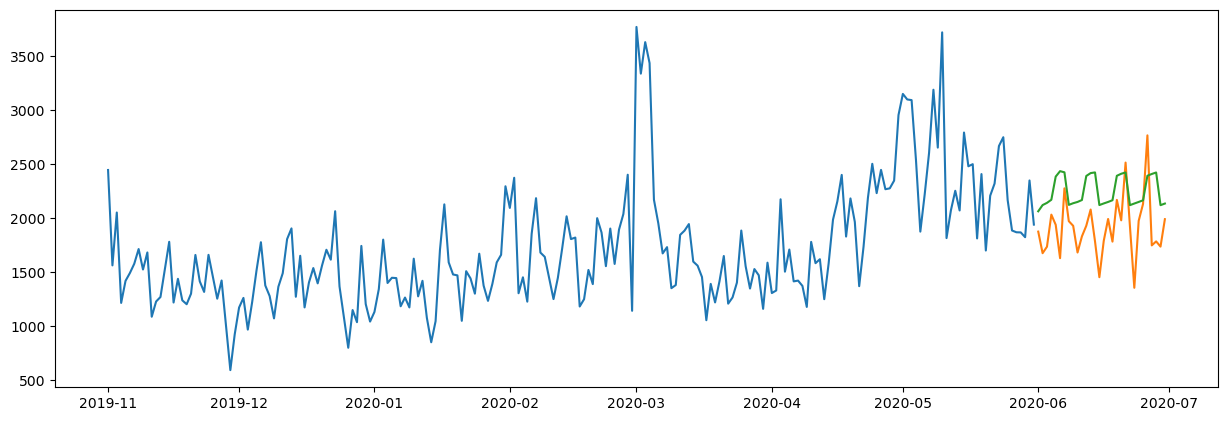

In [39]:
# restaurant 4 data with PotPie available for all 30 days of June(i.e in test data)
rest4_df.loc['2020-06-01':'2020-06-30','PotPieAv'] = 1

# Forescat test data with this change
_,for_PP_av,_ = build_arimax(rest4_df['total_sale'],1,1,1,1,0,1,7,211,rest4_df[cols])

                                     SARIMAX Results                                     
Dep. Variable:                        total_sale   No. Observations:                  211
Model:             SARIMAX(1, 1, 1)x(1, 0, 1, 7)   Log Likelihood               -1472.763
Date:                           Thu, 19 Nov 2020   AIC                           2965.526
Time:                                   15:16:25   BIC                           2998.559
Sample:                                        0   HQIC                          2978.892
                                           - 211                                         
Covariance Type:                             opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
month        308.7028     81.476      3.789      0.000     149.013     468.393
weekday       14.9861     23.238      0.645

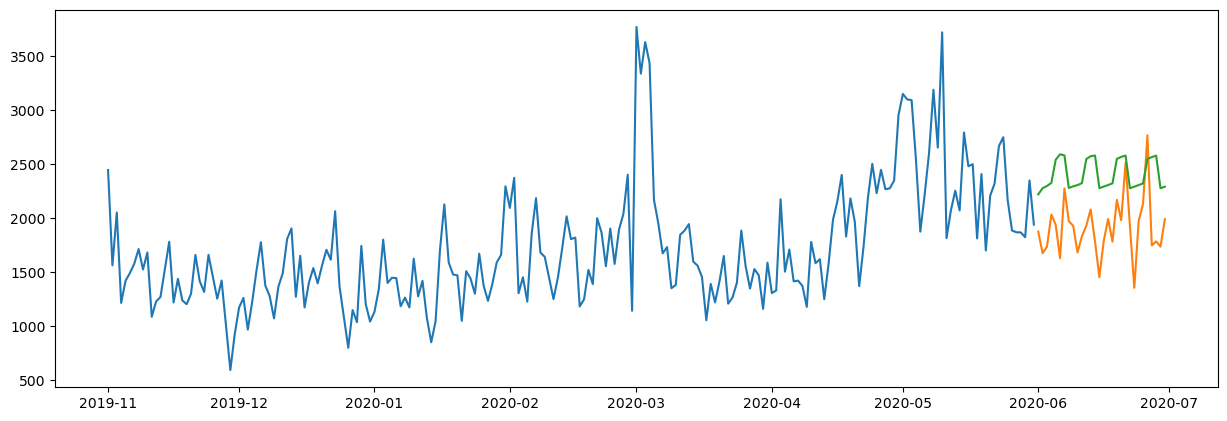

In [40]:
# restaurant 4 data with PotPie not available for all 30 days of June(i.e in test data)
rest4_df.loc['2020-06-01':'2020-06-30','PotPieAv'] = 0

# Forecast test data with this change
_,for_PP_nav,_ = build_arimax(rest4_df['total_sale'],1,1,1,1,0,1,7,211,rest4_df[cols])

(array([737577., 737581., 737585., 737589., 737593., 737597., 737601.,
        737605., 737607.]),
 <a list of 9 Text major ticklabel objects>)

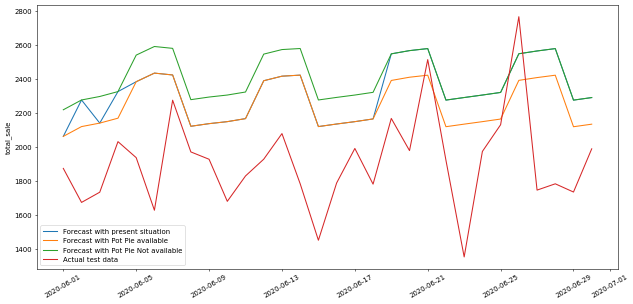

In [41]:
## Plot for forecast with present situation, with PotPieAv=0, with PotPieAv=1 and actual sales time series
index = pd.date_range('2020-06-01','2020-06-30')
plt.figure(figsize=(15,7),dpi=50)
plt.plot(index,fore,label='Forecast with present situation')
plt.plot(index,for_PP_av, label='Forecast with Pot Pie available')
plt.plot(index,for_PP_nav, label = 'Forecast with Pot Pie Not available')
plt.plot(index,tes, label='Actual test data')
plt.ylabel('total_sale')
plt.legend()
plt.xticks(rotation=30)

Interestingly, If you carefully look at blue line(Forecast with actual situation) in above plot it shows initial couple week(when Pot pie available) it was following orange line and then(remaining 15 days when pot pie not available) following green line. or else refer following plot.

<b>Conclusion:
It means removing Pot Pie category will lead to increase in sale. As customer may get divert to the other category and cause increase in daily total sale(based on our forecasting model).
It is also motivating to observe that, actual test data also follows our conclusion.(Refer following plot)</b>

(array([737577., 737581., 737585., 737589., 737593., 737597., 737601.,
        737605., 737607.]),
 <a list of 9 Text major ticklabel objects>)

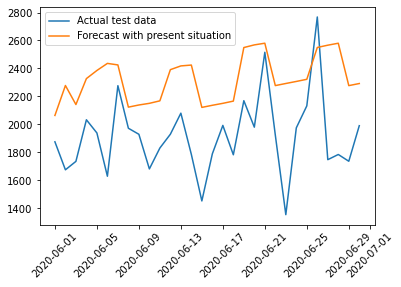

In [42]:
plt.plot(index,tes, label='Actual test data')
plt.plot(index,fore,label='Forecast with present situation')
plt.legend()
plt.xticks(rotation=45)

In [43]:
# mean change in forecast 
print('Mean change in forecast if we keep PotPie category and completely remove is:{:.3f}'.format(np.mean(abs(for_PP_av - for_PP_nav))))

Mean change in forecast if we keep PotPie category and completely remove is:156.470


Therefore we will choose SARIMAX as our final model for our second problem statement.It overforecast most of the time. 

### Is overestimate harmful?
According to my opinion, It is fine to have little bit overestimated model if we are using this forecast for managing our menu/category at the restaurant.Because, Removing or adding certain category will not cause short of any raw material due to overestimated forecast.

<a id='6'></a>
## 6. Prediction for July month(Holdout dates):

For this we will use whole available data for training and predict for month of July. For the sake of accuracy, we will have two seperate models for these problem statements.

For problem statement 1 we will use <b>SARIMA</b>. Because that is the best model among all if we are not making any changes to in day to day category.

For problem statement 2 we will use <b>SARIMAX</b>, in order to get rough estimate of change in daily sale due to removal of any category.

We will use experimentally fixed hyperparameters for both models and keeping same for all restaurants, because the daily total sale time series are kind of silmilar in nature for all restaurant.

In [44]:
## Building holdout set with features
index = pd.date_range('2020-07-01','2020-07-31')
holdout = pd.DataFrame(data = index, columns=['busy_dt'])
holdout = create_features(holdout)

In [45]:
## eliminating Pot Pie from the menu for month of July
holdout['PotPieAv'] = 0
# holdout.set_index('busy_dt',inplace=True)

In [46]:
# Find out dates on which restaurants were close
train = rest_df[rest_df['restaurant_id'] == 0].copy()
dates_drop = pd.date_range(start='2019-11-01',end='2020-06-30').difference(train['busy_dt'])
dates_drop

DatetimeIndex(['2019-11-28', '2019-12-25'], dtype='datetime64[ns]', freq=None)

In [47]:
# Problem Statement 1 - Prediction for all restaurant

output = pd.DataFrame()

def eval_sarima(t):
    train = t.copy()
    model = sm.tsa.statespace.SARIMAX(train['total_sale'],order=(1,1,1),seasonal_order=(1,0,1,7)).fit()
    f = model.predict(start=241,end=271,dynamic=True)
    return f

for id in range(0,5):
    d = rest_df[rest_df['restaurant_id']==id].copy()
    inp = d.reset_index(drop=True).copy()
    fore = eval_sarima(inp)
    s = 'restaurant_'+str(id)+'_sale'
    output[s] = fore.copy()
    
output.reset_index(inplace=True, drop=True)
output['busy_dt'] = index

<b>Assumption:</b>
1. For July month, all categories will be available all the days for all restaurants except Pot Pie.

In [48]:
# Problem Statement 2 - Prediction for all restaurant when PotPie is absent for July

output1 = pd.DataFrame()

def eval_sarimax(t,te,cols):
    train = t.copy()
    model = sm.tsa.statespace.SARIMAX(train['total_sale'],order=(1,1,1),seasonal_order=(1,0,1,7), exog=t[cols]).fit()
    f = model.predict(start=241,end=271,dynamic=True, exog=te[cols])
    return f

for id in range(0,5):
    d = rest_df[rest_df['restaurant_id']==id].copy()
    inp = d.reset_index(drop=True).copy()
    try:
        fore = eval_sarimax(inp,holdout,cols)
    except np.linalg.LinAlgError:
        print('Train data have\'nt seen absence of PotPie category')
        print('Therefore, Prdiction for restarant {} has been skipped'.format(id))
        continue
    s = 'restaurant_'+str(id)+'_sale'
    output1[s] = fore.copy()
    
output1.reset_index(inplace=True, drop=True)
output1['busy_dt'] = index

Train data have'nt seen absence of PotPie category
Therefore, Prdiction for restarant 3 has been skipped


In [49]:
output.head()

,restaurant_0_sale,restaurant_1_sale,restaurant_2_sale,restaurant_3_sale,restaurant_4_sale,busy_dt
0,2942.910876,1495.272889,2341.027220,1761.815201,1941.497754,2020-07-01
1,2951.344409,1476.160085,2265.060204,1726.083496,1964.995806,2020-07-02
2,3216.078006,1467.750144,2455.910315,1978.746262,2177.226576,2020-07-03
3,3080.087173,1479.874421,2330.896240,1700.371751,2019.151917,2020-07-04
4,3127.062705,1458.322762,2455.317037,1818.594854,2146.601404,2020-07-05


In [50]:
output1.head()

,restaurant_0_sale,restaurant_1_sale,restaurant_2_sale,restaurant_4_sale,busy_dt
0,2419.529417,1271.329978,1626.807260,1157.374733,2020-07-01
1,2369.277896,1237.126412,1648.164093,1164.848277,2020-07-02
2,2816.237598,1345.065060,1794.024258,1425.996246,2020-07-03
3,2695.725089,1338.194200,1826.107566,1294.260051,2020-07-04
4,2651.579504,1294.243677,1861.809070,1373.209971,2020-07-05


In [51]:
## Writing Output to CSV file
output.to_csv('Part1_PS1_all_restaurant_daily_sales_prediction', index= False)
output1.to_csv('Part1_PS2_all_restaurant_daily_sales_prediction',index = False)

<b> Caution: Please don't compare forecast drawn for these two problem statement against each other to understand the change in behvior of customer due to removel of Pot Pie category. Because these forecast drawn from two different models. </b>

<a id='7'></a>
## 7. Future Scope:

We can extend our work in future in following way:
1. Try out more models to improve the accuracy. They could be xgboost or grdient boost by adding some lag features or deep learning models.
3. Can add holiday and festive season as exogenous variable in case of ARIMAX/SARIMAX.
2. If we will have large amount of temporal data(atleast a year), then we can use one hot encoding instead of label encoding. It seems very strange to hear about encoding but with current model and current data one hot encoding creating technical glitch.
3. With large data, we can add additional time related features. For e.g. year
4. With large amount of temporal data, we can have peak forecasting as seperate problem statement. This investigation will help us to understand the sale on peak season and manage our inventory at store.
